In [1]:
import time
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import umap.umap_ as umap
from IPython.display import Audio, display

device = torch.device("cpu")

In [2]:
# copy-paste this URL into your browser in order to use this function.
def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
    
allDone()

In [3]:
amino_acids = 'XWGSAELQDMPFTRIHVNCY_K'

def letterToIndex(letter):
    return amino_acids.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, len(amino_acids))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, len(amino_acids))
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def getSampForTesting(myMotifs,mIdx):
    
    motif = myMotifs[mIdx]
    motif_tensor = lineToTensor(motif)

    mIdx_batch = [motif_tensor]

    motif_idc = [letterToIndex(aa) for aa in motif]
    motif_idc = torch.tensor(motif_idc)

    mIdx_batch = torch.nn.utils.rnn.pad_sequence(mIdx_batch, batch_first=False).squeeze(2)

    maxLen = mIdx_batch.shape[0]
            
    return (mIdx_batch, maxLen)

def saveEmbedding(myModel,myMotifs,myFileName):
    embeds = []
    BATCH_SIZE = 1

    myModel.eval()

    for idx in range(len(myMotifs)):
        (mIdx_batch, maxLen) = getSampForTesting(myMotifs,idx)
        mIdx_batch = mIdx_batch.to(device)
        embed = myModel.forward_once(BATCH_SIZE,mIdx_batch)
        embed = embed.squeeze()
        embeds.append(embed.cpu().detach().numpy())

    df = pd.DataFrame(embeds,dtype=float)
    df.to_csv(myFileName,header=None,index=None)
    
    return embeds

In [4]:
motifs_train = (np.genfromtxt('data_filtered/motifs_train.csv',dtype='U'))
motifxFamMatrix_train = np.genfromtxt('data_filtered/motifxFamMatrix_train.csv',delimiter=',',dtype=int)

motifs_test = (np.genfromtxt('data_filtered/motifs_test.csv',dtype='U'))
motifxFamMatrix_test = np.genfromtxt('data_filtered/motifxFamMatrix_test.csv',delimiter=',',dtype=int)

motifs_all = np.hstack((motifs_train,motifs_test))
motifs_all.shape

motifxFamMatrix_all = np.vstack((motifxFamMatrix_train,motifxFamMatrix_test))
motifxFamMatrix_all.shape

fams = (np.genfromtxt('data_filtered/fams.csv',dtype='U'))

In [5]:
HIDDEN_DIM_0 = 250
HIDDEN_DIM_1 = HIDDEN_DIM_0 * 2
HIDDEN_DIM_PER_AA = 100 

OUT_DIM = 15*HIDDEN_DIM_PER_AA

class SiameseNet(nn.Module):
        
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.lstm = nn.LSTM(len(amino_acids), HIDDEN_DIM_0, num_layers=2, bidirectional=True)
        self.h1 = nn.Sequential(nn.Linear(HIDDEN_DIM_0*2, HIDDEN_DIM_1),
                                 nn.ReLU()) 
        self.h_out = nn.Linear(HIDDEN_DIM_1, HIDDEN_DIM_PER_AA)
    
    def forward_once(self, BATCH_SIZE, sentence):  
        lstm_out, (h,c) = self.lstm( sentence )
        h1 = self.h1( lstm_out )
        h_out = self.h_out( h1 )
        h_out = h_out.reshape(BATCH_SIZE,OUT_DIM)
        return h_out
        
    def forward(self, input1, input2, BATCH_SIZE):
        embed = self.forward_once(BATCH_SIZE, input1)
        embed2 = self.forward_once(BATCH_SIZE, input2)
        return (embed, embed2)

In [6]:
len(amino_acids)

22

In [7]:
model = SiameseNet() 
model.load_state_dict(torch.load('model_siamese'))

<All keys matched successfully>

In [8]:
myEmbeds = saveEmbedding(model,motifs_all,"embedding_siamese_all.csv")
_ = saveEmbedding(model,motifs_test, "embedding_siamese_test.csv")
_ = saveEmbedding(model,motifs_train, "embedding_siamese_train.csv")

allDone()

## Produce UMAP projections if desired.

In [9]:
umapper = umap.UMAP(
    n_neighbors=200,
    min_dist=0.1,
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(myEmbeds)
allDone()

print ("secs: %5.3f" % (time.time()-s))

/usr/local/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../usr/local/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/usr/local/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../usr/local/anaconda3/lib/python3.7/site-package

secs: 58.857


In [10]:
f = 'siamese_yourFigs/'
os.mkdir(f)

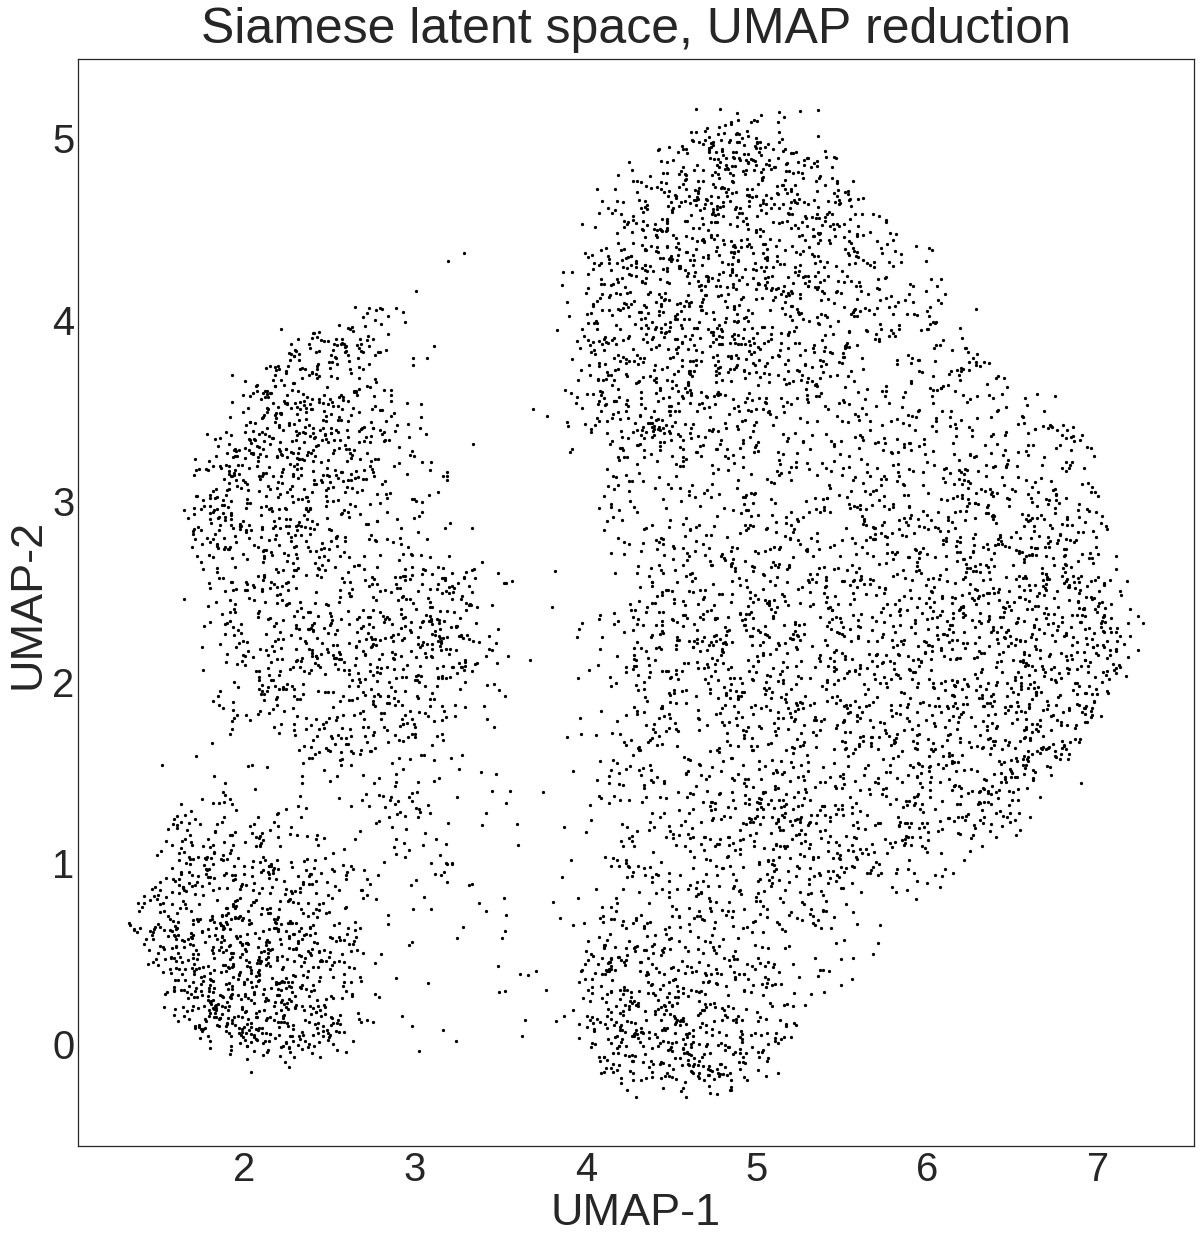

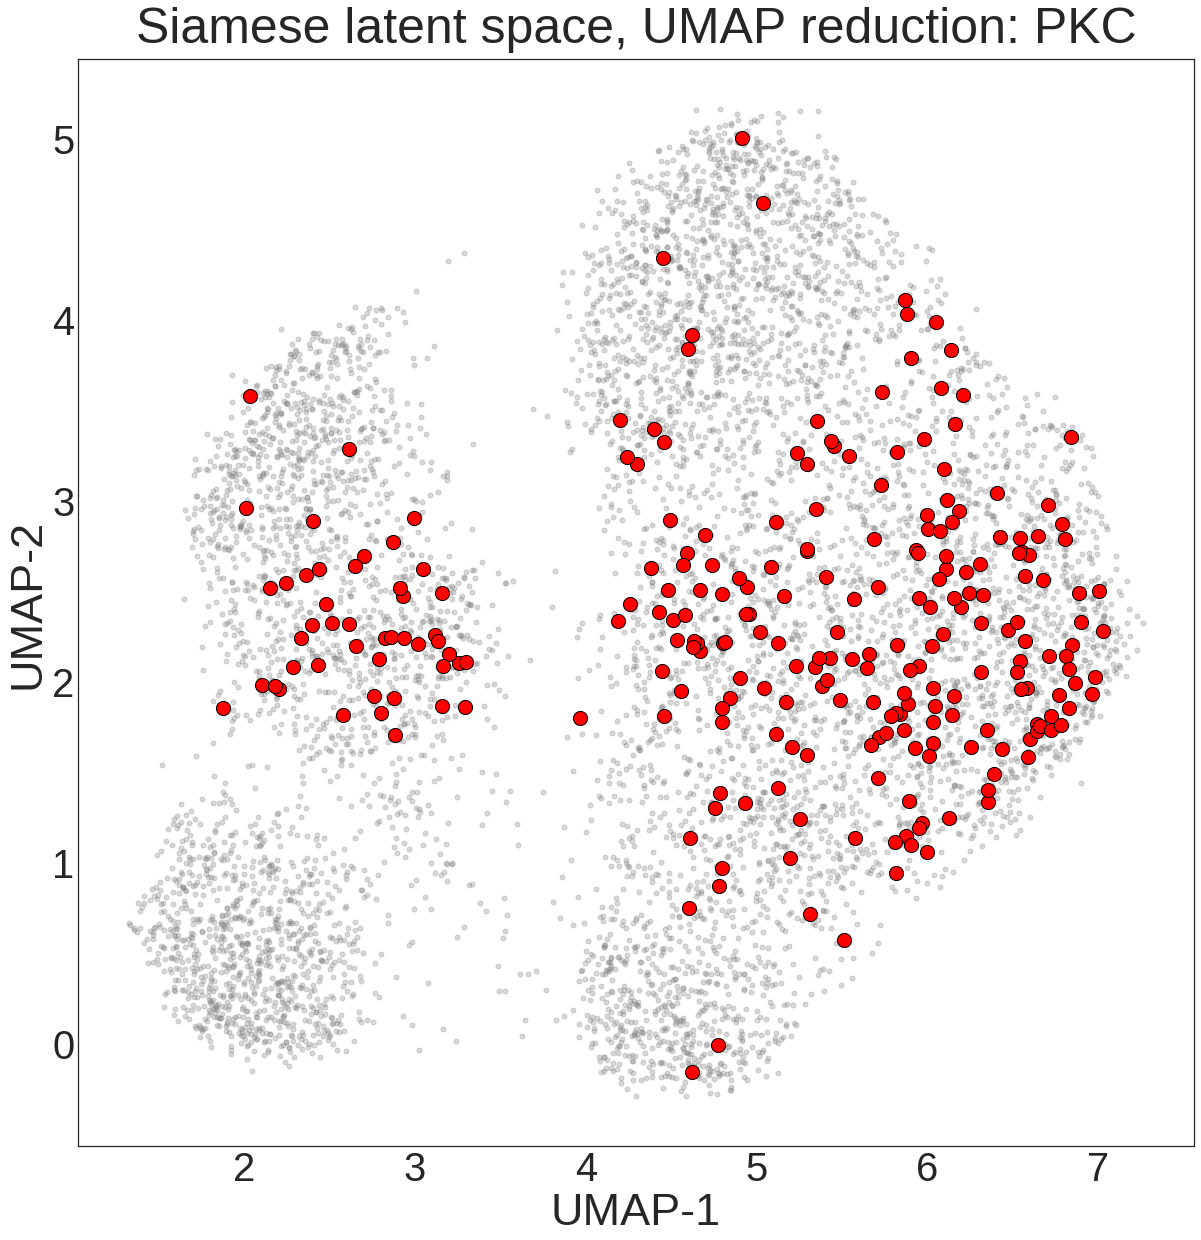

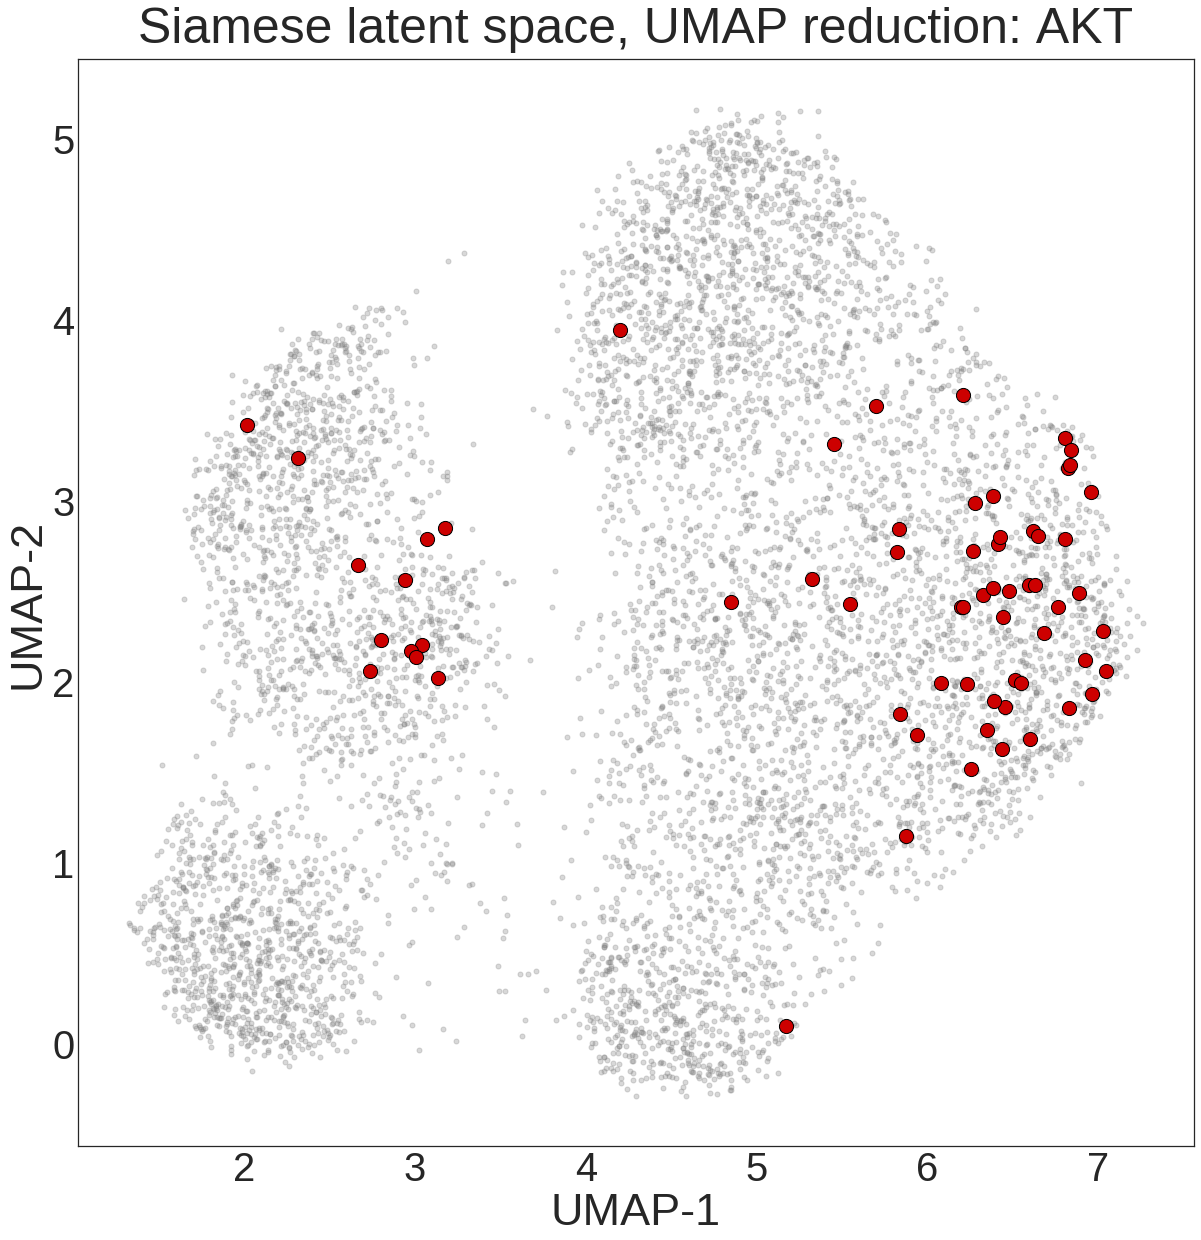

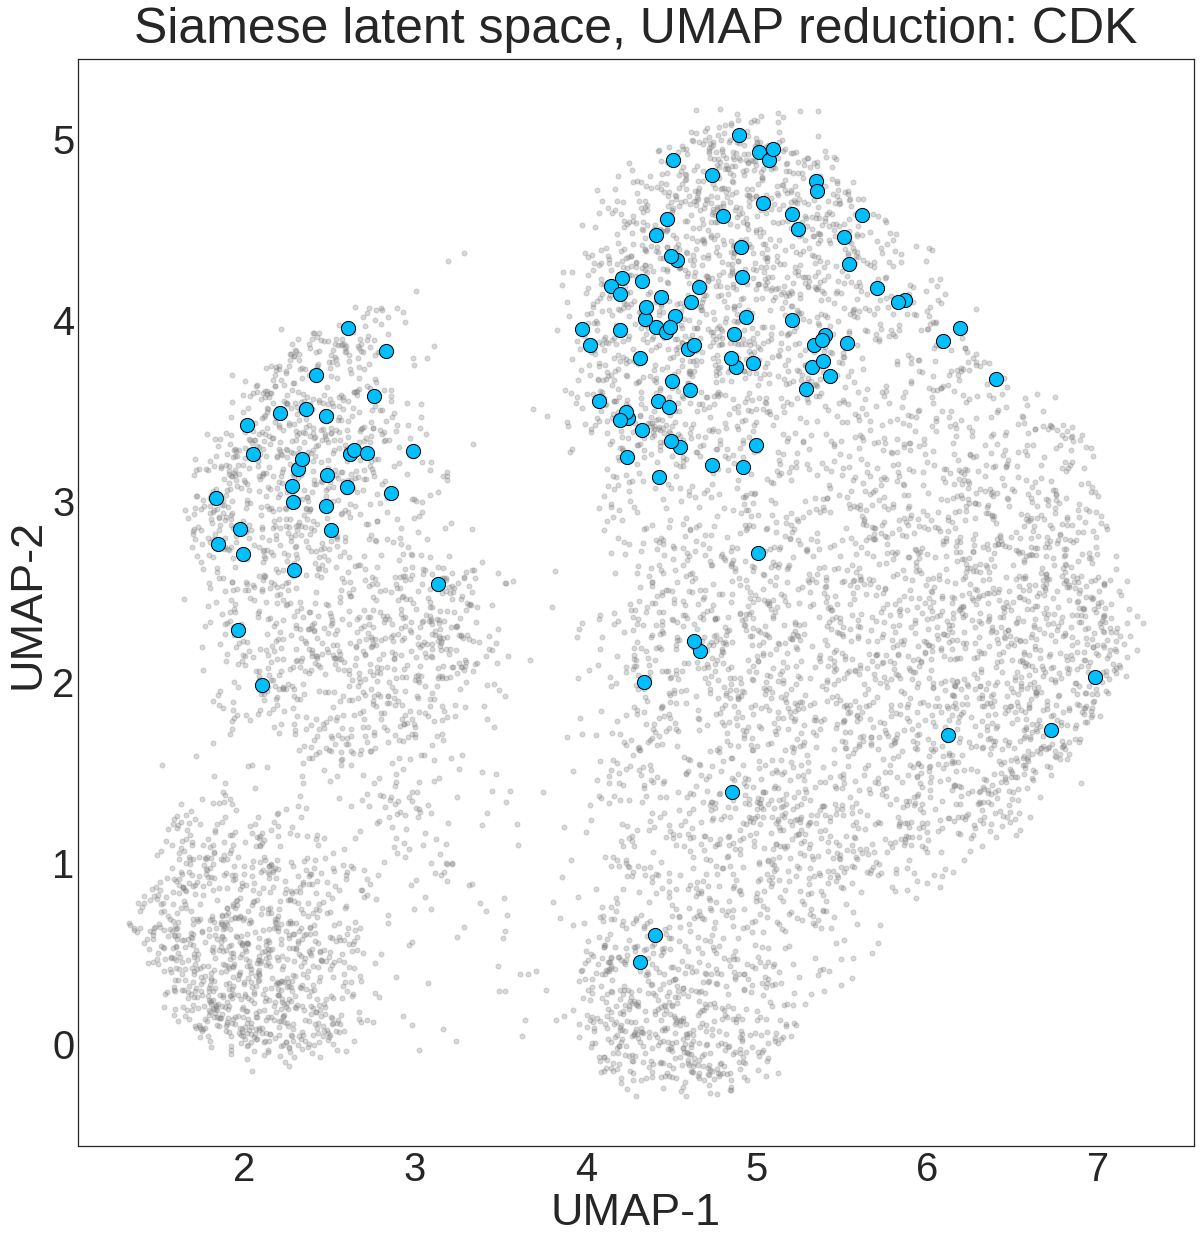

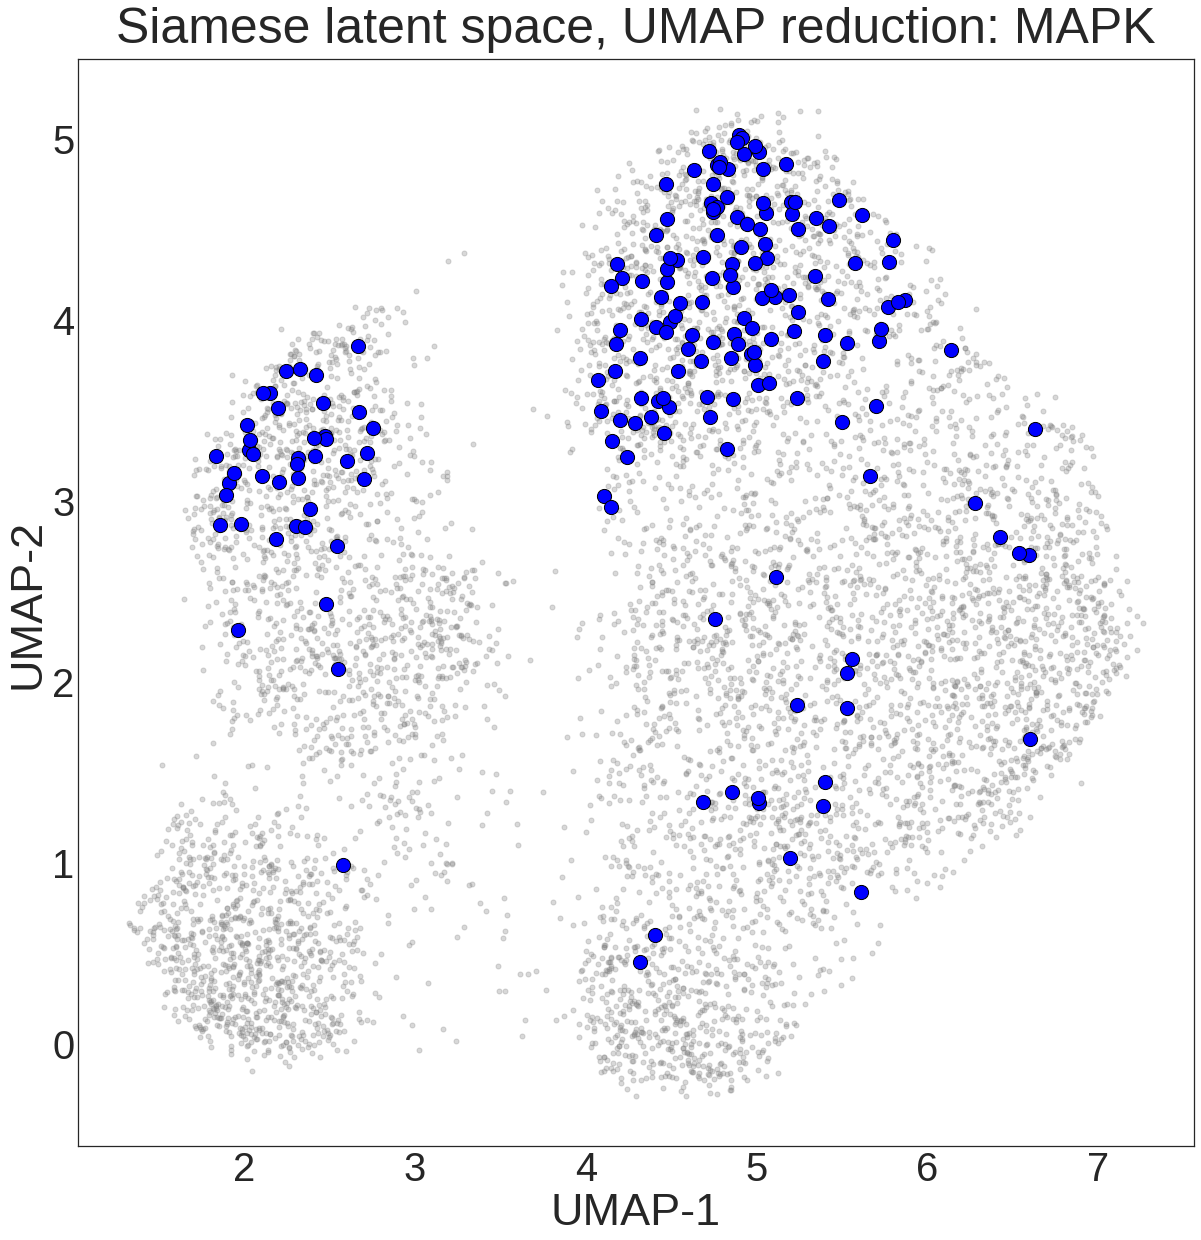

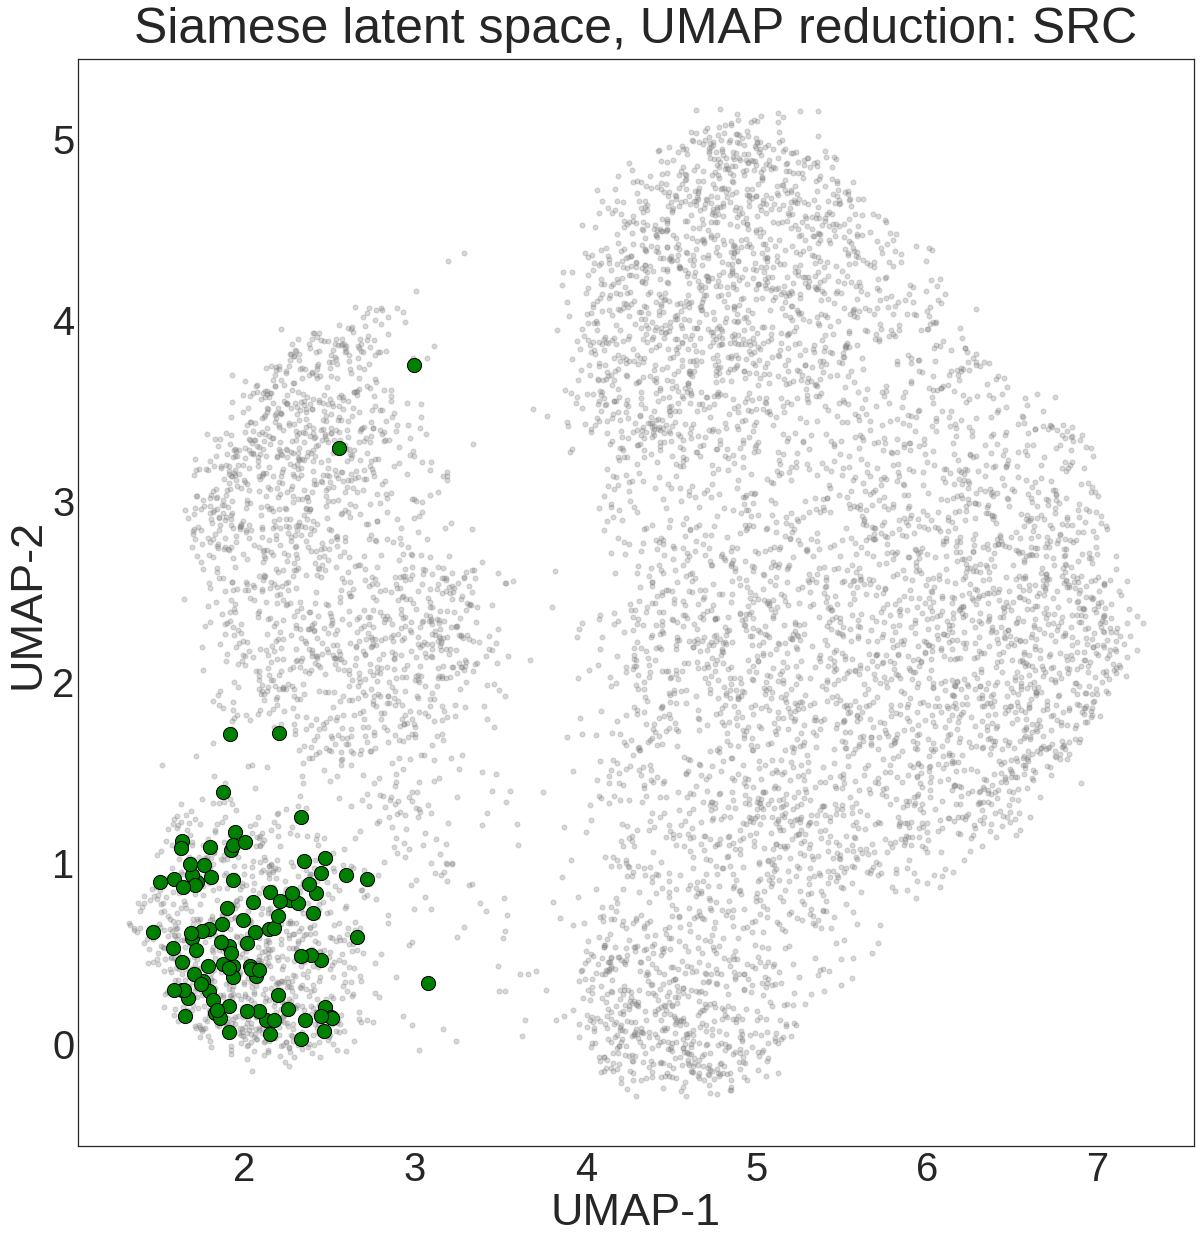

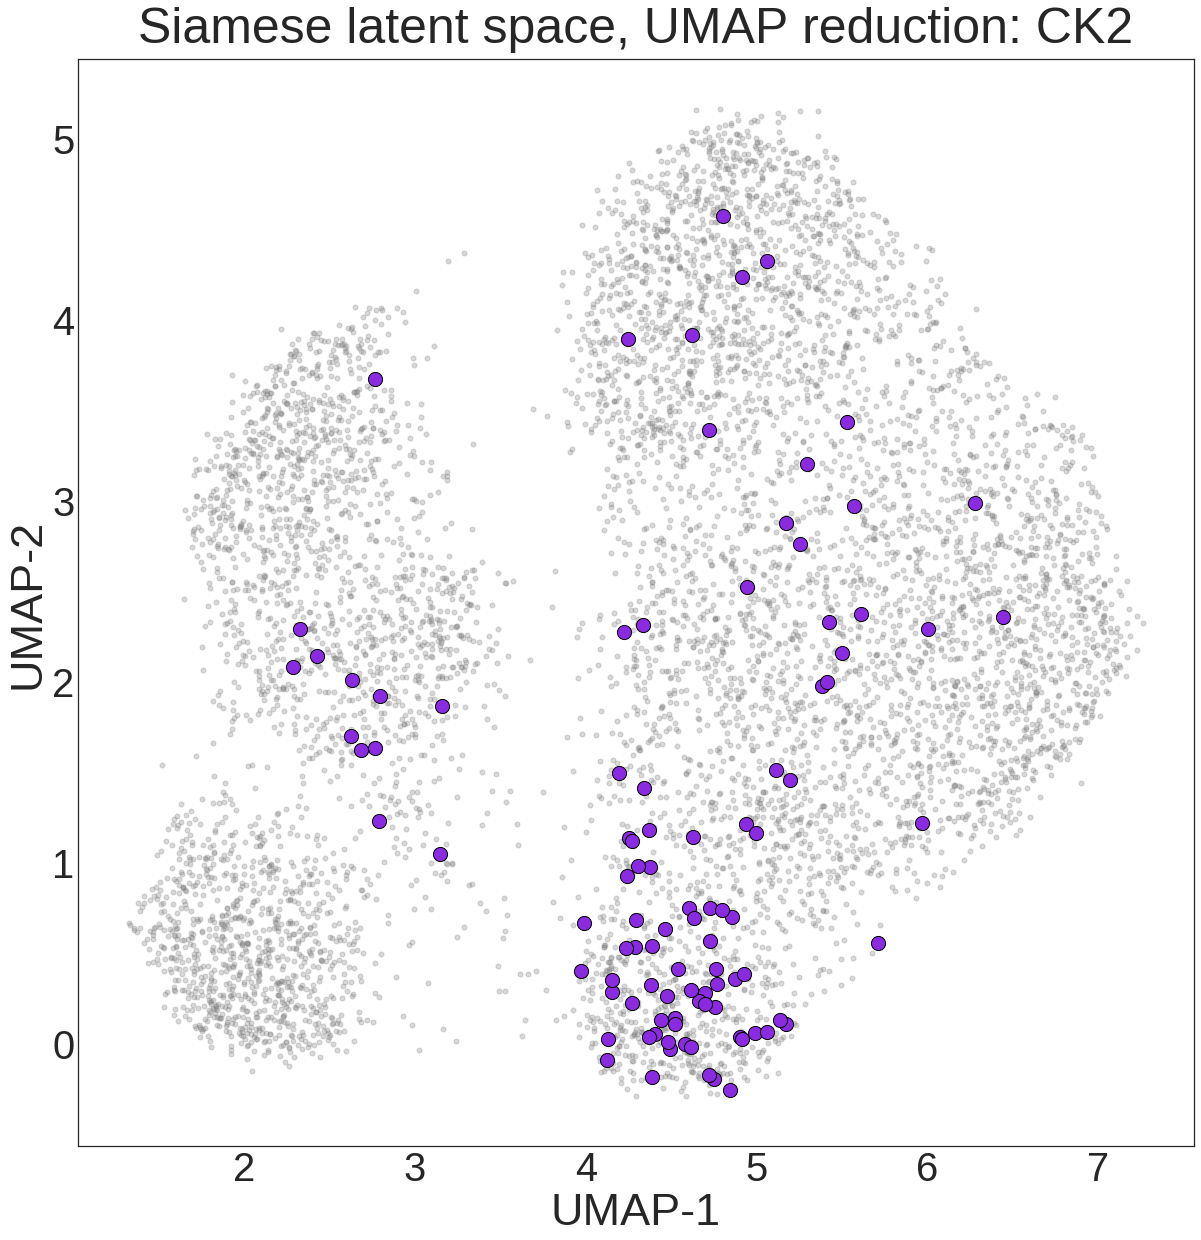

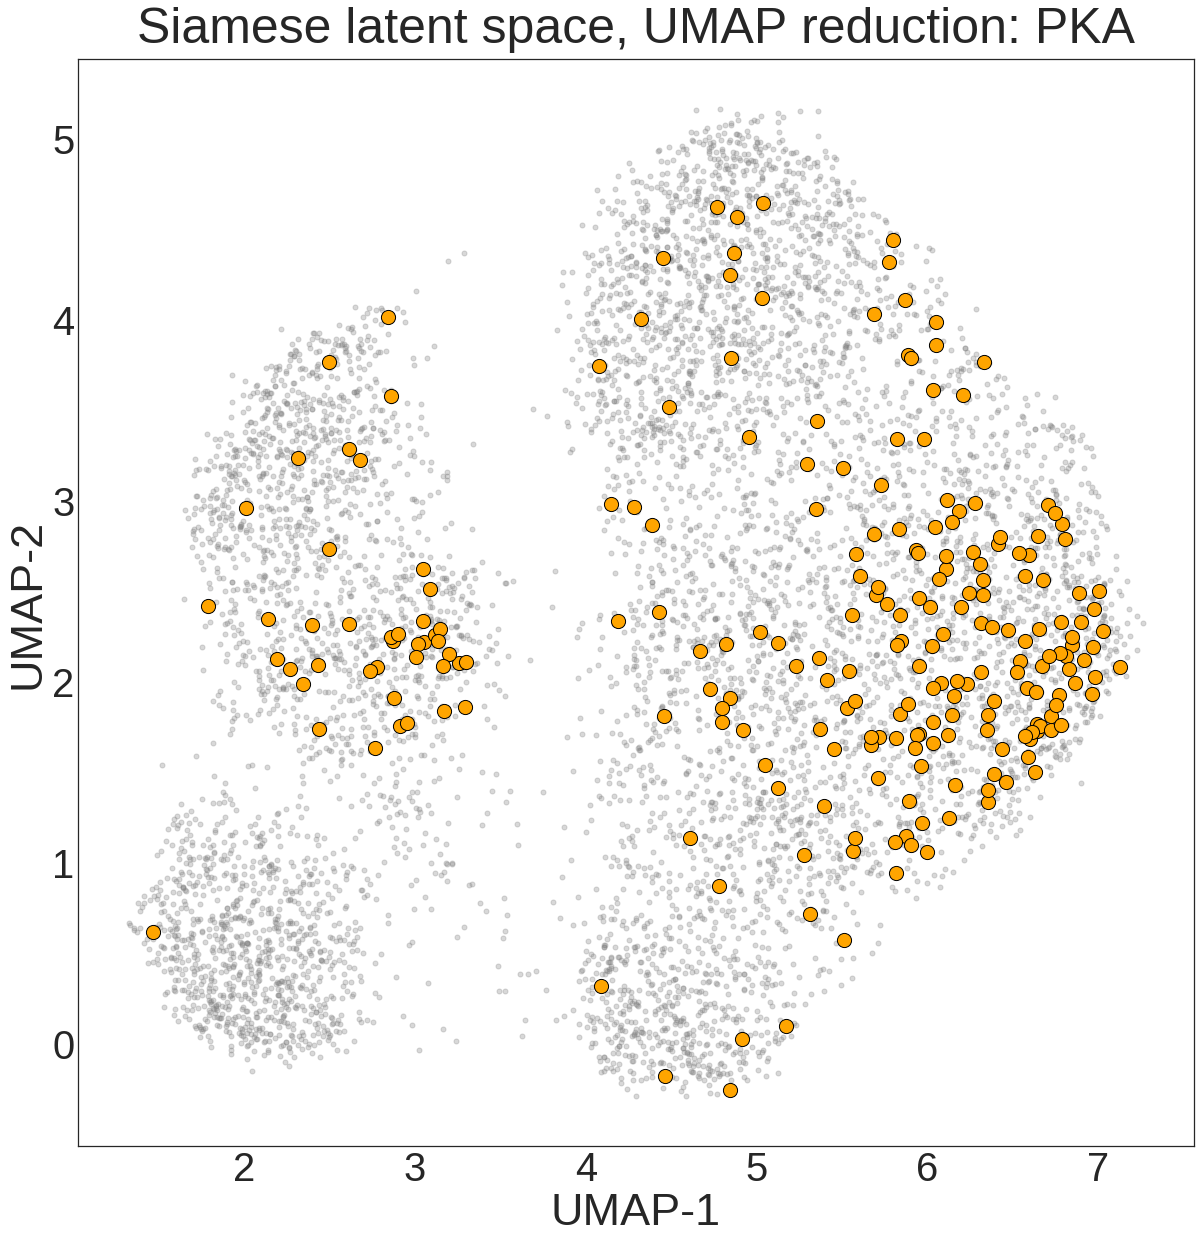

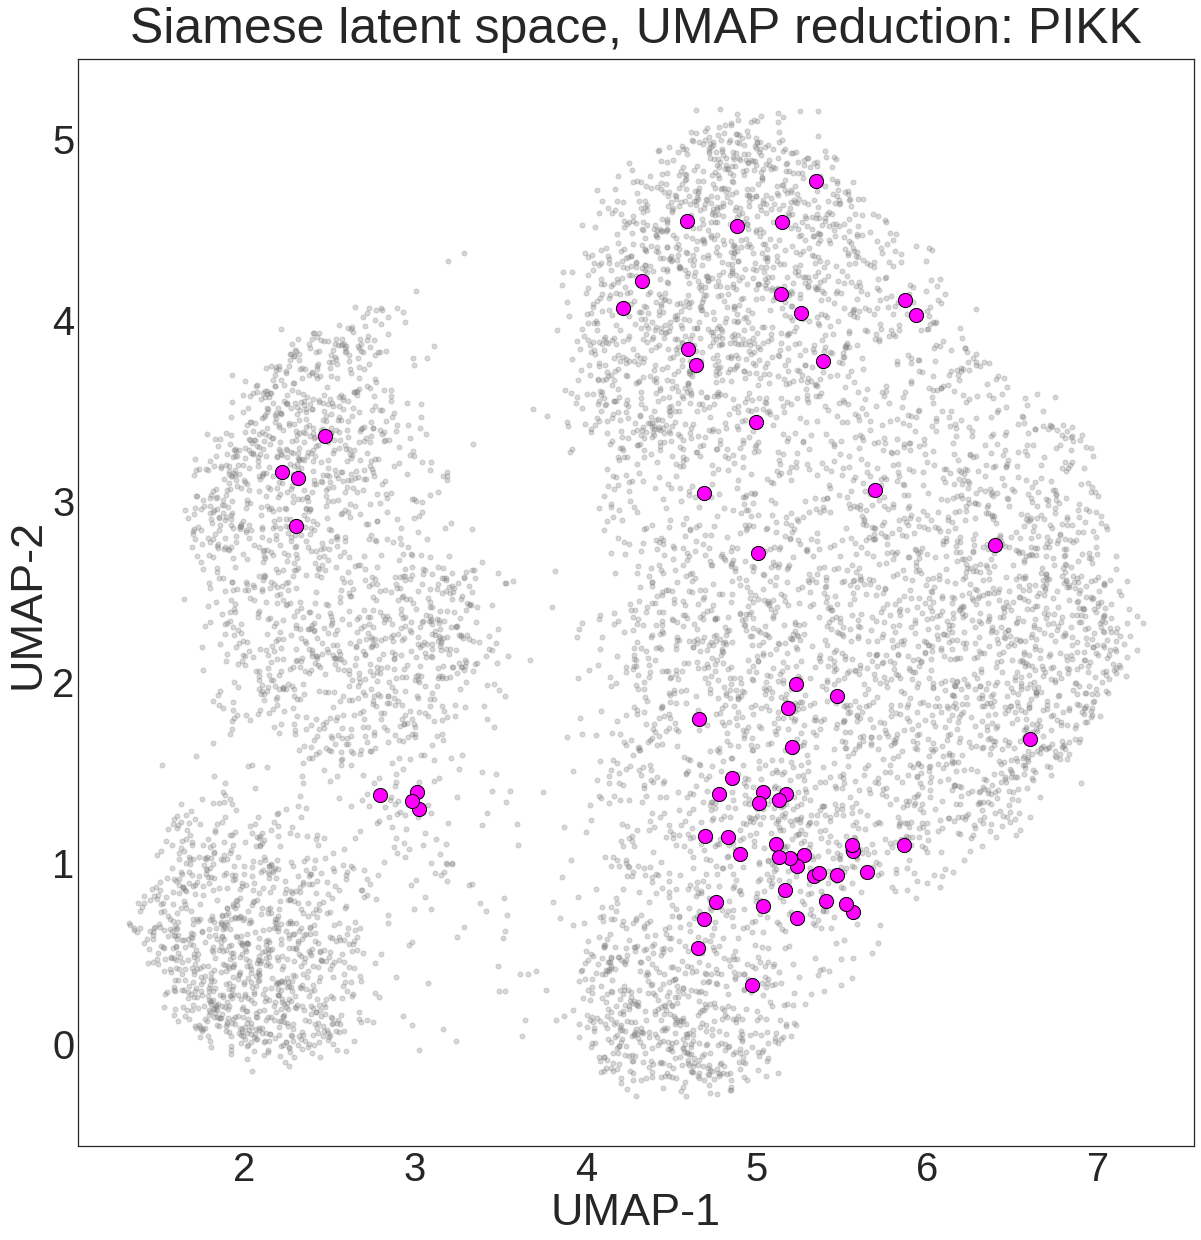

In [11]:
label_size = 45
title_size = 50
tick_size = 40

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

colors = ['red','#CD0000','deepskyblue','blue','green','blueviolet','orange','magenta','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)
plt.title("Siamese latent space, UMAP reduction",fontsize=title_size,y=1.01)
plt.xlabel("UMAP-1",fontsize=label_size)
plt.ylabel("UMAP-2",fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig( f + "noHighlights")
plt.show()

pop_fams = ['PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']

i = -1
for _,fam in enumerate(pop_fams):
    
    i+=1
    fIdx = np.where(fams==fam)[0][0]
    plt.figure(figsize=(20,20))
    plt.title(("Siamese latent space, UMAP reduction: %s" % fam),fontsize=title_size,y=1.01)
    plt.xticks(fontsize=tick_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    plt.yticks(fontsize=tick_size)
    plt.xlabel("UMAP-1",fontsize=label_size)
    plt.ylabel("UMAP-2",fontsize=label_size)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=25,color='grey',alpha=0.30)
    for mIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if motifs_all[mIdx] not in motifs_test:
            continue
        elif motifxFamMatrix_all[mIdx][fIdx]==1:
            plt.scatter(x,y,marker='o',s=200,c=colors[i],alpha=1.0,edgecolors='black')          
    plt.savefig((f+"%s_200" % fam))
    plt.show()